In [ ]:
# %pip install tensorflow==2.4.1
# %pip install pyarrow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import os
import math
from math import ceil

In [ ]:
model_iteration = 'V2_iteration_1'

##### Loading all test data predictions that were created from the previous notebook

In [ ]:
test_data = pd.read_parquet(f"/content/drive/My Drive/Colab Notebooks/mag_model/test_data_{model_iteration}/predictions_20220117_lr0006_beta025_gamma28_nH6_nL4_firstD2048_secondD1024_thirdD1024.parquet")
test_data['target_test'] = test_data['target_tok'].apply(lambda x: [i for i in x if i!=-1])
test_data['target_test'] = test_data['target_test'].apply(len)
test_data = test_data[test_data['target_test'] > 0].copy()
test_data.shape

(62517, 10)

##### Loading raw/extra data for all test samples

In [ ]:
test_extra_data = pd.read_parquet(f"/content/drive/My Drive/Colab Notebooks/mag_model/test_data_{model_iteration}/extra_test_data.parquet") \
[['paper_id','year','month','full_topic_len','lang','doc_type','original_title','clean_title','abstract_length',
  'clean_abstract','topics_full']]
test_extra_data.shape

(62524, 11)

In [ ]:
test_data_all = test_data \
.merge(test_extra_data, how='left', on='paper_id')
test_data_all.shape

(62517, 20)

In [ ]:
test_data_all = test_data_all[test_data_all['lang']=='en'].copy()
test_data_all.shape

(58621, 20)

In [ ]:
test_data_all['abstract_length'].describe()

count    41969.000000
mean       171.269508
std         88.517156
min         31.000000
25%        111.000000
50%        159.000000
75%        216.000000
max        996.000000
Name: abstract_length, dtype: float64

In [ ]:
test_data_all['short_topic_len'] = test_data_all['target_tok'].apply(len)

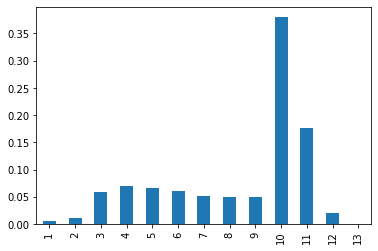

In [ ]:
(test_data_all['full_topic_len'].value_counts()/(test_data_all['full_topic_len'].value_counts().sum())) \
.sort_index().plot.bar()

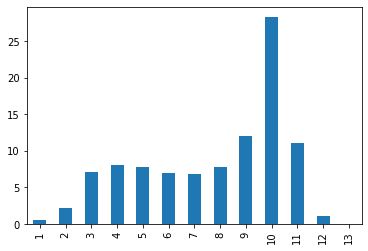

In [ ]:
(test_data_all['short_topic_len'].value_counts()*100/(test_data_all['short_topic_len'].value_counts().sum())) \
.sort_index().plot.bar()

In [ ]:
test_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58621 entries, 0 to 62516
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paper_id          58621 non-null  int64  
 1   publication_date  58621 non-null  object 
 2   doc_type_tok      58621 non-null  object 
 3   journal_tok       58621 non-null  object 
 4   target_tok        58621 non-null  object 
 5   paper_title_tok   58621 non-null  object 
 6   abstract_tok      58621 non-null  object 
 7   predictions       58621 non-null  object 
 8   scores            58621 non-null  object 
 9   target_test       58621 non-null  int64  
 10  year              58621 non-null  int64  
 11  month             58621 non-null  int64  
 12  full_topic_len    58621 non-null  int64  
 13  lang              58621 non-null  object 
 14  doc_type          58621 non-null  object 
 15  original_title    58621 non-null  object 
 16  clean_title       58621 non-null  object

##### Loading all vocabs used

In [ ]:
with open(f"/content/drive/My Drive/Colab Notebooks/mag_model/vocab_{model_iteration}/topics_vocab.pkl", "rb") as f:
    target_vocab = pickle.load(f)
    
target_vocab_inv = {j:i for i,j in target_vocab.items()}

with open(f"/content/drive/My Drive/Colab Notebooks/mag_model/vocab_{model_iteration}/doc_type_vocab.pkl", "rb") as f:
    doc_vocab = pickle.load(f)
    
doc_vocab_inv = {j:i for i,j in doc_vocab.items()}

with open(f"/content/drive/My Drive/Colab Notebooks/mag_model/vocab_{model_iteration}/journal_name_vocab.pkl", "rb") as f:
    journal_vocab = pickle.load(f)
    
journal_vocab_inv = {j:i for i,j in journal_vocab.items()}

with open(f"/content/drive/My Drive/Colab Notebooks/mag_model/vocab_{model_iteration}/paper_title_vocab.pkl", "rb") as f:
    title_vocab = pickle.load(f)
    
title_vocab_inv = {j:i for i,j in title_vocab.items()}


In [ ]:
print(len(target_vocab_inv))

65026


In [ ]:
test_data_all.head(1)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,abstract_tok,predictions,scores,target_test,year,month,full_topic_len,lang,doc_type,original_title,clean_title,abstract_length,clean_abstract,topics_full,short_topic_len
0,18863665,2011-01-01,[8],[2],"[16572, 48550, 52758, 32648, 9593, 44014, 4264...","[239113, 92190, 154991, 132270, 265955, 114561...","[154201, 47075, 139417, 222311, 200157, 90902,...","[27479, 52758, 9593, 42648, 44646, 13543, 5080...","[0.9208367466926575, 0.5991209745407104, 0.569...",11,2011,1,11,en,BookChapter,A Graph Theoretic Approach to Atomic Displacem...,a graph theoretic approach to atomic displacem...,96.0,the recently developed idea of analyzing compl...,"[complex network, laplacian matrix, node, math...",11


In [ ]:
test_data_all['topics_target'] = test_data_all['target_tok'].apply(lambda x: [target_vocab_inv.get(i) for i in x])
test_data_all['predictions_text'] = test_data_all['predictions'].apply(lambda x: [target_vocab_inv.get(i) for i in x])

In [ ]:
encoding_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=len(target_vocab)+1, output_mode="binary", sparse=False)

##### Loading Concept Levels Data

In [ ]:
levels_df = pd.read_parquet(f"/content/drive/My Drive/Colab Notebooks/mag_model/universal_test_data/tag_levels.parquet").fillna(6)
levels_df['level'] = levels_df['level'].astype('int')

In [ ]:
levels_df.head()

,topic_name,level
0,picard horn,5
1,anti zionism,4
2,localizer performance with vertical guidance,5
3,chrysoderma,3
4,antiparallelogram,2


In [ ]:
levels_0_1 = [target_vocab.get(x) for x in levels_df[levels_df['level'].isin([0,1])]['topic_name'].to_list()]

In [ ]:
with open(f"/content/drive/My Drive/Colab Notebooks/mag_model/vocab_{model_iteration}/level_0_1_ids.pkl", 'wb') as f:
  pickle.dump(levels_0_1, f)

In [ ]:
def dual_thresh_preds(preds, scores, levels, threshold_1=0.31, threshold_2=0.42):
    temp_preds_1 = [x for x,y in zip(preds, scores) if y >= threshold_1]
    temp_preds_2 = [x for x,y in zip(preds, scores) if y >= threshold_2]

    new_preds_0_1 = [x for x in temp_preds_1 if x in levels]
    new_preds_2_plus = [x for x in temp_preds_2 if x not in levels]

    new_preds_all = list(set(new_preds_0_1 + new_preds_2_plus))

    if len(new_preds_all) == 0:
        new_preds = preds[:1]
    else:
        new_preds = [x for x in preds if x in new_preds_all]
    return new_preds

In [ ]:
for thresh_1, thresh_2 in zip([31,32,31,32],[41,41,42,42]):
    print(f"--------------Thresholds: {thresh_1} and {thresh_2}--------------")
    test_data_all[f'predictions_{str(thresh_1)}_{str(thresh_2)}'] = test_data_all.apply(lambda x: dual_thresh_preds(x.predictions, x.scores, levels_0_1, thresh_1/100, thresh_2/100), axis=1)
    test_data_all[f'predictions_{str(thresh_1)}_{str(thresh_2)}_text'] = test_data_all[f'predictions_{str(thresh_1)}_{str(thresh_2)}'].apply(lambda x: [target_vocab_inv.get(i) for i in x])

--------------Thresholds: 31 and 41--------------
--------------Thresholds: 32 and 41--------------
--------------Thresholds: 31 and 42--------------
--------------Thresholds: 32 and 42--------------


### Getting Metrics

In [ ]:
def get_metrics_text(data, target_col, predict_col):
    targets = data[target_col].to_list()
    predictions = data[predict_col].to_list()

    num_tags = len(target_vocab)
    num_topics = 718000
    num_targets = len([x for y in targets for x in y])
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    weighted_acc = 0
    for i,j in zip(predictions, targets):
      try:
        tp_temp = len([x for x in i if x in j])
        fp_temp = len([x for x in i if x not in j])
        fn_temp = len([x for x in j if x not in i])
        weighted_acc += tp_temp/len(j)
        TP += tp_temp
        FP += fp_temp
        FN += fn_temp
        TN += (num_tags - TP - FP - FN)
    except:
        print(i)
        print(j)
        print(type(i))
        print(type(j))
  
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    f1_score = 2*(recall*precision)/(recall+precision)
    accuracy = TP/num_targets
    weighted_acc = weighted_acc/len(predictions)

    print(f"Recall: {round(recall*100, 1)}%")
    print(f"Precision: {round(precision*100, 1)}%")
    print(f"F1 Score: {round(f1_score*100, 1)}%")
    print(f"Accuracy: {round(accuracy*100, 1)}%")
    print(f"Weighted Accuracy: {round(weighted_acc*100, 1)}%")

    return TP,FP,TN,FN


In [ ]:
def compare_two_columns(data, target_col, predict_col_one, predict_col_two):
    print(predict_col_one)
    tp_1, fp_1, tn_1, fn_1 = get_metrics_text(data, target_col, predict_col_one)
    print("\n")
    print(predict_col_two)
    tp_2, fp_2, tn_2, fn_2 = get_metrics_text(data, target_col, predict_col_two)
    print("\n")

    print(f"TP percent increase: {round((tp_2-tp_1)/tp_1*100,1)}% ({tp_2-tp_1})")
    print(f"FP percent increase: {round((fp_2-fp_1)/fp_1*100,1)}% ({fp_2-fp_1})")
    print(f"FN percent increase: {round((fn_2-fn_1)/fn_1*100,1)}% ({fn_2-fn_1})")

### Looking at different probability thresholds

In [ ]:
for col in ['predictions_31_41_text','predictions_31_42_text','predictions_32_41_text','predictions_32_42_text']:
    print(f"--------------{col}--------------")
    _ = get_metrics_text(test_data_all, 'topics_target', col)

--------------predictions_31_41_text--------------
Recall: 68.8%
Precision: 58.8%
F1 Score: 63.4%
Accuracy: 68.8%
Weighted Accuracy: 68.8%
--------------predictions_31_42_text--------------
Recall: 67.7%
Precision: 59.6%
F1 Score: 63.4%
Accuracy: 67.7%
Weighted Accuracy: 67.9%
--------------predictions_32_41_text--------------
Recall: 68.3%
Precision: 59.7%
F1 Score: 63.7%
Accuracy: 68.3%
Weighted Accuracy: 68.2%
--------------predictions_32_42_text--------------
Recall: 67.3%
Precision: 60.6%
F1 Score: 63.7%
Accuracy: 67.2%
Weighted Accuracy: 67.3%


### Levels

In [ ]:
def fill_blank(arr):
    if not type(arr) == list:
        arr=["NO TAGS FOR THIS"]
    return arr

In [ ]:
def get_df_for_specific_level(old_df, levels, level_to_get=1, pred_col="predictions", target_col='topics_target'):
    df = old_df.copy()
    curr_topics = pd.DataFrame(zip(target_vocab.keys()), columns=['topic_name'])
    tags_list = levels[levels['level']==level_to_get].merge(curr_topics, how='inner', on='topic_name')['topic_name'].to_list()
    print(f"Number of Tags: {len(tags_list)}")


    df_preds = df.explode(pred_col).merge(levels[levels['level']==level_to_get], 
                                          how='inner', left_on=pred_col, right_on='topic_name')
    
    df_targs = df.explode(target_col).merge(levels[levels['level']==level_to_get], 
                                            how='inner', left_on=target_col, right_on='topic_name')
    
    df_preds_1 = df_preds[['paper_id',pred_col]].groupby('paper_id')[pred_col].apply(list).reset_index()
    df_targs_2 = df_targs[['paper_id',target_col]].groupby('paper_id')[target_col].apply(list).reset_index()

    new_df = df_preds_1.merge(df_targs_2, how='outer', on='paper_id')
    
    papers_with_tag = (new_df[~new_df[target_col].isnull()].shape[0])/df.shape[0]
    papers_with_pred = (new_df[~new_df[pred_col].isnull()].shape[0])/df.shape[0]

    new_df[target_col] = new_df[target_col].apply(lambda x: fill_blank(x))
    new_df[pred_col] = new_df[pred_col].apply(lambda x: fill_blank(x))
    
    print(f"Percentage of papers with Level {level_to_get} Tags: {round(papers_with_tag*100, 1)}")
    print(f"Percentage of papers with Level {level_to_get} Preds: {round(papers_with_pred*100, 1)}")
    
    return new_df

In [ ]:
thresh = "32_41"

In [ ]:
print(f"predictions_{thresh}_text")
for level_to_check in range(0,6):
    print(f"Topic Level: {level_to_check}")
    df = get_df_for_specific_level(test_data_all, levels_df, level_to_check, f"predictions_32_41_text")
    get_metrics_text(df, 'topics_target', f'predictions_32_41_text')
    print("------------------------------------------------------------")
    print("\n")

predictions_32_41_text
Topic Level: 0
Number of Tags: 19
Percentage of papers with Level 0 Tags: 99.5
Percentage of papers with Level 0 Preds: 99.1
Recall: 87.3%
Precision: 65.9%
F1 Score: 75.1%
Accuracy: 87.3%
Weighted Accuracy: 87.3%
------------------------------------------------------------


Topic Level: 1
Number of Tags: 291
Percentage of papers with Level 1 Tags: 99.5
Percentage of papers with Level 1 Preds: 95.5
Recall: 71.4%
Precision: 46.8%
F1 Score: 56.5%
Accuracy: 71.3%
Weighted Accuracy: 73.2%
------------------------------------------------------------


Topic Level: 2
Number of Tags: 25178
Percentage of papers with Level 2 Tags: 93.2
Percentage of papers with Level 2 Preds: 93.1
Recall: 66.2%
Precision: 61.4%
F1 Score: 63.7%
Accuracy: 66.2%
Weighted Accuracy: 65.9%
------------------------------------------------------------


Topic Level: 3
Number of Tags: 24533
Percentage of papers with Level 3 Tags: 74.9
Percentage of papers with Level 3 Preds: 73.6
Recall: 60.2%
Pre

### Journal and Doc Types

In [ ]:
test_data_all['journal'] = test_data_all['journal_tok'].apply(lambda x: [journal_vocab_inv.get(i) for i in x][0])
test_data_all['doc_type'] = test_data_all['doc_type_tok'].apply(lambda x: [doc_vocab_inv.get(i) for i in x][0])

In [ ]:
for doc_type in test_data_all['doc_type'].value_counts().index:
    print(doc_type)
    get_metrics_text(test_data_all[test_data_all['doc_type']==doc_type], "topics_target", f"predictions_{thresh}_text")
    print("-----------------------------------------------------------------------")
    print("\n")

Journal
Recall: 68.9%
Precision: 60.2%
F1 Score: 64.3%
Accuracy: 68.9%
Weighted Accuracy: 69.0%
-----------------------------------------------------------------------


Conference
Recall: 65.0%
Precision: 57.3%
F1 Score: 60.9%
Accuracy: 65.0%
Weighted Accuracy: 65.1%
-----------------------------------------------------------------------


Repository
Recall: 70.0%
Precision: 59.3%
F1 Score: 64.2%
Accuracy: 70.0%
Weighted Accuracy: 71.0%
-----------------------------------------------------------------------


Book
Recall: 56.9%
Precision: 53.7%
F1 Score: 55.3%
Accuracy: 56.9%
Weighted Accuracy: 56.3%
-----------------------------------------------------------------------


Thesis
Recall: 60.8%
Precision: 54.3%
F1 Score: 57.4%
Accuracy: 60.8%
Weighted Accuracy: 61.1%
-----------------------------------------------------------------------


BookChapter
Recall: 59.7%
Precision: 53.0%
F1 Score: 56.1%
Accuracy: 59.6%
Weighted Accuracy: 57.6%
------------------------------------------------

### Paper Title Length

In [ ]:
# 0 - 10, 10 - 20, 20+

In [ ]:
test_data_all['paper_title_tok_len'] = test_data_all['paper_title_tok'].apply(len)

In [ ]:
(test_data_all[test_data_all['paper_title_tok_len'] < 10].shape[0])/test_data_all.shape[0]

0.27398031422186586

In [ ]:
(test_data_all[(test_data_all['paper_title_tok_len'] >= 10) & (test_data_all['paper_title_tok_len']<20)].shape[0])/test_data_all.shape[0]

0.6182937855034885

In [ ]:
(test_data_all[(test_data_all['paper_title_tok_len'] >= 20) & (test_data_all['paper_title_tok_len']<40)].shape[0])/test_data_all.shape[0]

0.10591767455348766

In [ ]:
get_metrics_text(test_data_all[test_data_all['paper_title_tok_len'] < 10], "topics_target", f"predictions_{thresh}_text")

Recall: 65.3%
Precision: 58.1%
F1 Score: 61.5%
Accuracy: 65.3%
Weighted Accuracy: 64.7%


(71200, 51266, -245909054, 37850)

In [ ]:
get_metrics_text(test_data_all[(test_data_all['paper_title_tok_len'] >= 10) & (test_data_all['paper_title_tok_len']<20)], "topics_target", f"predictions_{thresh}_text")

Recall: 69.2%
Precision: 60.1%
F1 Score: 64.3%
Accuracy: 69.2%
Weighted Accuracy: 69.5%


(203847, 135429, -5450690987, 90825)

In [ ]:
get_metrics_text(test_data_all[(test_data_all['paper_title_tok_len'] >= 20) & (test_data_all['paper_title_tok_len']<40)], "topics_target", f"predictions_{thresh}_text")

Recall: 69.9%
Precision: 61.1%
F1 Score: 65.2%
Accuracy: 69.9%
Weighted Accuracy: 70.1%


(35862, 22803, 173223617, 15431)

### Time

In [ ]:
explore_time = test_data_all.copy()

In [ ]:
explore_time['yearMonth'] = explore_time['year']*100+explore_time['month']

In [ ]:
get_metrics_text(explore_time[explore_time['year'] <= 2002], "topics_target", f"predictions_{thresh}_text")

Recall: 66.9%
Precision: 60.5%
F1 Score: 63.5%
Accuracy: 66.9%
Weighted Accuracy: 66.8%


(78654, 51420, -329131445, 38898)

In [ ]:
get_metrics_text(explore_time[(explore_time['year'] >= 2003) & (explore_time['year'] <= 2008)], "topics_target", f"predictions_{thresh}_text")

Recall: 68.1%
Precision: 60.5%
F1 Score: 64.1%
Accuracy: 68.1%
Weighted Accuracy: 68.0%


(39068, 25541, 168819829, 18309)

In [ ]:
get_metrics_text(explore_time[(explore_time['year'] >= 2009) & (explore_time['year'] <= 2014)], "topics_target", f"predictions_{thresh}_text")

Recall: 67.6%
Precision: 60.6%
F1 Score: 63.9%
Accuracy: 67.6%
Weighted Accuracy: 67.7%


(58160, 37769, 31734752, 27857)

In [ ]:
get_metrics_text(explore_time[(explore_time['year'] >= 2015) & (explore_time['year'] <= 2020)], "topics_target", f"predictions_{thresh}_text")

Recall: 68.6%
Precision: 59.7%
F1 Score: 63.9%
Accuracy: 68.6%
Weighted Accuracy: 68.6%


(59683, 40261, 13995950, 27318)

In [ ]:
get_metrics_text(explore_time[(explore_time['year'] == 2021) & (explore_time['yearMonth'] < 202106)], "topics_target", f"predictions_{thresh}_text")

Recall: 68.8%
Precision: 56.0%
F1 Score: 61.7%
Accuracy: 68.8%
Weighted Accuracy: 68.8%


(4338, 3415, 50553942, 1969)

In [ ]:
get_metrics_text(explore_time[(explore_time['year'] == 2021) & (explore_time['yearMonth'] >= 202106)], "topics_target", f"predictions_{thresh}_text")

Recall: 70.4%
Precision: 58.2%
F1 Score: 63.7%
Accuracy: 70.4%
Weighted Accuracy: 70.3%


(71377, 51369, -135204077, 30039)

### Abstract null vs not null

In [ ]:
get_metrics_text(test_data_all[test_data_all['abstract_length'].isnull()], "topics_target", f"predictions_{thresh}_text")

Recall: 62.1%
Precision: 56.1%
F1 Score: 58.9%
Accuracy: 62.1%
Weighted Accuracy: 63.6%


(49032, 38429, 106603115, 29887)

In [ ]:
get_metrics_text(test_data_all[~test_data_all['abstract_length'].isnull()], "topics_target", f"predictions_{thresh}_text")

Recall: 69.6%
Precision: 60.5%
F1 Score: 64.7%
Accuracy: 69.6%
Weighted Accuracy: 70.0%


(262248, 171346, -8785336297, 114503)

### Looking at L0 Topic Performance

In [ ]:
def get_df_for_all_levels(old_df, levels, topic_to_get, pred_col="predictions", target_col='topics_target'):
    df = old_df.copy()
    # curr_topics = pd.DataFrame(zip(target_vocab.keys()), columns=['topic_name'])
    # tags_list = levels[levels['level']==0].merge(curr_topics, how='inner', on='topic_name')['topic_name'].to_list()
    # print(f"Number of Tags: {len(tags_list)}")

    df_preds = df.explode(pred_col)
    papers_with_topic_preds = df_preds[df_preds[pred_col]==topic_to_get][['paper_id']]
    df_preds = df.merge(papers_with_topic_preds, how='inner', on='paper_id')
    
    df_targs = df.explode(target_col)
    papers_with_topic_targs = df_targs[df_targs[target_col]==topic_to_get][['paper_id']]
    df_targs = df.merge(papers_with_topic_targs, how='inner', on='paper_id')
    
    df_preds_1 = df_preds[['paper_id',pred_col]] #.groupby('paper_id')[pred_col].apply(list).reset_index()
    df_targs_2 = df_targs[['paper_id',target_col]] #.groupby('paper_id')[target_col].apply(list).reset_index()

    new_df = df_preds_1.merge(df_targs_2, how='outer', on='paper_id')
    
    papers_with_tag = (new_df[~new_df[target_col].isnull()].shape[0])/df.shape[0]
    papers_with_pred = (new_df[~new_df[pred_col].isnull()].shape[0])/df.shape[0]

    final_df = df.merge(pd.concat([df_preds, df_targs], axis=0).drop_duplicates(subset=['paper_id'])[['paper_id']], 
                        how='inner', on='paper_id')

    final_df[target_col] = final_df[target_col].apply(lambda x: fill_blank(x))
    final_df[pred_col] = final_df[pred_col].apply(lambda x: fill_blank(x))
    
    print(f"Percentage of papers with Topic {topic_to_get} Tags: {round(papers_with_tag*100, 1)}")
    print(f"Percentage of papers with Topic {topic_to_get} Preds: {round(papers_with_pred*100, 1)}")
    
    return final_df

In [ ]:
for topic in levels_df[levels_df['level']==0]['topic_name'].to_list():
    print(f"Topic: {topic}")
    df = get_df_for_all_levels(test_data_all, levels_df, topic, f'predictions_{thresh}_text')
    get_metrics_text(df, 'topics_target', f'predictions_{thresh}_text')
    print("------------------------------------------------------------")
    print("\n")

Topic: economics
Percentage of papers with Topic economics Tags: 2.1
Percentage of papers with Topic economics Preds: 2.4
Recall: 63.7%
Precision: 54.2%
F1 Score: 58.6%
Accuracy: 63.7%
Weighted Accuracy: 63.0%
------------------------------------------------------------


Topic: physics
Percentage of papers with Topic physics Tags: 4.4
Percentage of papers with Topic physics Preds: 4.8
Recall: 66.4%
Precision: 56.5%
F1 Score: 61.1%
Accuracy: 66.4%
Weighted Accuracy: 66.3%
------------------------------------------------------------


Topic: materials science
Percentage of papers with Topic materials science Tags: 12.4
Percentage of papers with Topic materials science Preds: 14.2
Recall: 72.4%
Precision: 60.8%
F1 Score: 66.1%
Accuracy: 72.4%
Weighted Accuracy: 72.1%
------------------------------------------------------------


Topic: medicine
Percentage of papers with Topic medicine Tags: 19.0
Percentage of papers with Topic medicine Preds: 25.1
Recall: 67.5%
Precision: 60.5%
F1 Score:

In [ ]:
sampled_data = test_data_all[['paper_id']].sample(100).merge(test_data_all, how='inner', on='paper_id').copy()
for i in range(100):
    targets = sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns=='topics_target'][0]]
    preds = sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns==f'predictions_{thresh}_text'][0]]
    tp_temp = len([x for x in preds if x in targets])
    fp_temp = len([x for x in preds if x not in targets])
    fn_temp = len([x for x in targets if x not in preds])
    tn_temp = len(target_vocab) - tp_temp - fp_temp - fn_temp
    print(sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns=='paper_id'][0]])
    print(sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns=='clean_title'][0]])
    print("\n")
    print(f"Full Tags: {sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns=='topics_full'][0]]}")
    print("\n")
    print(f"Target Tags: {targets}")
    print("\n")
    print(f"Predictions: {sampled_data.iloc[i,np.arange(0,len(sampled_data.columns))[sampled_data.columns==f'predictions_{thresh}_text'][0]]}")
    print("\n")
    print(f"TP: {tp_temp}   TN: {tn_temp}   FP: {fp_temp}   FN: {fn_temp}")
    print("----------------------------------------------------------------------")
    print("\n")

32_41
2607205193
preserved endothelial progenitor cell angiogenic activity in african american essential hypertensive patients


Full Tags: ['inferior vena cava' 'inflammation' 'internal medicine'
 'vascular endothelial growth factor' 'medicine' 'endocrinology'
 'essential hypertension' 'endothelial progenitor cell'
 'endothelial stem cell' 'progenitor cell' 'cytokine']


Target Tags: ['inferior vena cava', 'inflammation', 'internal medicine', 'vascular endothelial growth factor', 'medicine', 'endocrinology', 'essential hypertension', 'endothelial progenitor cell', 'endothelial stem cell', 'progenitor cell', 'cytokine']


Predictions: ['medicine', 'progenitor cell', 'angiogenesis', 'internal medicine', 'endothelial progenitor cell', 'endothelial stem cell', 'endocrinology', 'essential hypertension', 'vascular endothelial growth factor', 'cd34', 'endothelium', 'inflammation', 'endothelial activation', 'immunology']


TP: 9   TN: 65010   FP: 5   FN: 2
------------------------------------